In [1]:
# Script for training a denoiser
import os

os.environ['XLA_FLAGS']='--xla_gpu_cuda_data_dir=/gpfslocalsys/cuda/10.1.2'

In [2]:
import jax.numpy as jnp
import numpy as np 
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import gc
import jax, sys
import importlib
from jax.ops import index, index_add, index_update

In [3]:
sys.path = ['../'] + sys.path

In [4]:
from jax_lensing import wiener_sampling, spectral, inversion
importlib.reload(wiener_sampling)
importlib.reload(spectral)
importlib.reload(inversion)

<module 'jax_lensing.inversion' from '../jax_lensing/inversion.py'>

In [5]:
from astropy.io import fits

In [6]:
test_e = fits.open('../data/ktng/tests/ktng_cosmos_e360.fits')
test_e = test_e[0].data
test_kappa = fits.open('../data/ktng/tests/ktng_cosmos_kappa360.fits')
test_kappa = test_kappa[0].data
mask = fits.open('../data/COSMOS/cosmos_full_mask_0.29arcmin360copy.fits')
mask = mask[0].data
ps_ktng_th = jnp.load("../data/ktng/ktng_PS_theory.npy").astype('float32')

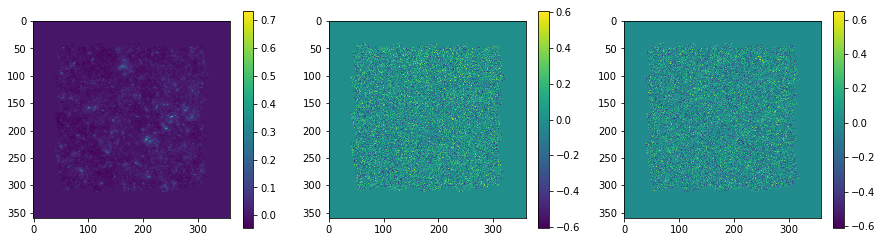

In [7]:
_ = plt.figure(figsize=(15,4))
_ = plt.subplot(131), plt.imshow(test_kappa*mask), plt.colorbar()
_ = plt.subplot(132), plt.imshow(test_e[:,:,0]), plt.colorbar()
_ = plt.subplot(133), plt.imshow(test_e[:,:,1]), plt.colorbar()

In [8]:
std_e1 = 0.148
ncov_diag_e1 = np.ones(test_kappa.shape)*std_e1*std_e1*mask + np.abs(1.-mask)*1e10
ncov_diag_e2 = np.ones(test_kappa.shape)*std_e1*std_e1*mask + np.abs(1.-mask)*1e10

In [9]:
resolution = 0.29 # arcmin/pixel
pixel_size = jnp.pi * resolution / 180. / 60. #rad/pixel

In [10]:
ps = spectral.measure_power_spectrum(test_kappa+1j*test_kappa*0.)
ps = index_update(ps, index[0], 0.)
ps = index_update(ps, index[128:], 0.)

In [11]:
kell = ps_ktng_th[0,:] / 2 / jnp.pi * pixel_size * 360
ps_th = ps_ktng_th[1,:] / pixel_size**2

k = np.arange(360)
ps_th_interp = jnp.interp(k, kell, ps_th)
ps_th_interp = index_update(ps_th_interp, index[0], 0.)
ps_th_interp = index_update(ps_th_interp, index[128:], 0.)

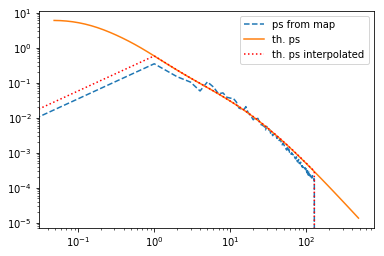

In [12]:
plt.loglog(ps, '--', label='ps from map')
plt.loglog(kell, ps_th, label='th. ps')
plt.loglog(ps_th_interp, ':', color='red', label='th. ps interpolated')
plt.legend()

/gpfslocalsup/pub/anaconda-py3/2020.02/envs/tensorflow-gpu-2.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/gpfslocalsup/pub/anaconda-py3/2020.02/envs/tensorflow-gpu-2.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


(<matplotlib.image.AxesImage at 0x148388069b90>,
 <matplotlib.colorbar.Colorbar at 0x1483800c98d0>)

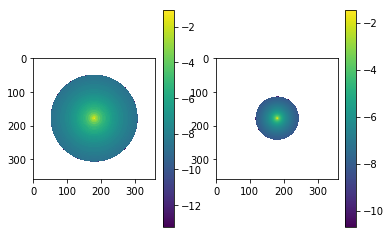

In [13]:
ps_map_ktng = jnp.fft.fftshift(spectral.make_power_map(ps,360))
ps_map_ktng = index_update(ps_map_ktng, index[180,180], 0.)

plt.subplot(121)
plt.imshow((np.log(ps_map_ktng.real))), plt.colorbar()

ps_th_map = jnp.fft.fftshift(spectral.make_power_map(ps_th_interp,360))
ps_th_map = index_update(ps_th_map, index[180,180], 0.)

plt.subplot(122)
plt.imshow((np.log(ps_th_map.real))), plt.colorbar()

## Choose Power Spectrum

In [14]:
# Use the Power Spectrum from a map
#ps_map = ps_map_ktng

# Use the thoertical Power Spectrum
ps_map = ps_th_map

In [15]:
wf_e1, wf_e2 = wiener_sampling.spin_wiener_filter_jit(test_e[:,:,0]+1j*test_kappa*0., test_e[:,:,1]+1j*test_kappa*0., ncov_diag_e1,ncov_diag_e2, ps_map, ps_map*0., iterations=20)
wf_e, wf_b = inversion.ks93(wf_e1, wf_e2)

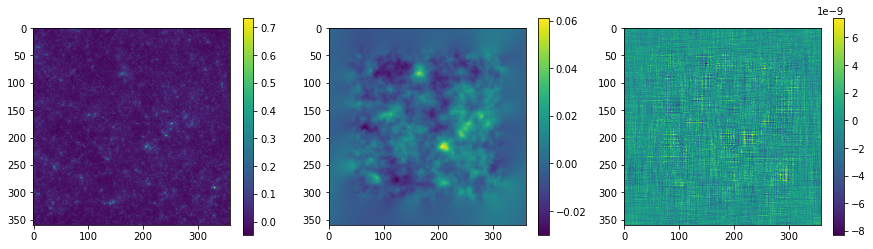

In [16]:
_ = plt.figure(figsize=(15,4))
_ = plt.subplot(131), plt.imshow(test_kappa), plt.colorbar()
_ = plt.subplot(132), plt.imshow(wf_e), plt.colorbar()
_ = plt.subplot(133), plt.imshow(wf_b), plt.colorbar()

In [17]:
wf_e1, wf_e2 = wiener_sampling.spin_wiener_filter(test_e[:,:,0]+1j*test_kappa*0., test_e[:,:,1]+1j*test_kappa*0., ncov_diag_e1,ncov_diag_e2, ps_map, ps_map*0., iterations=20)
wf_e, wf_b = inversion.ks93(wf_e1, wf_e2)

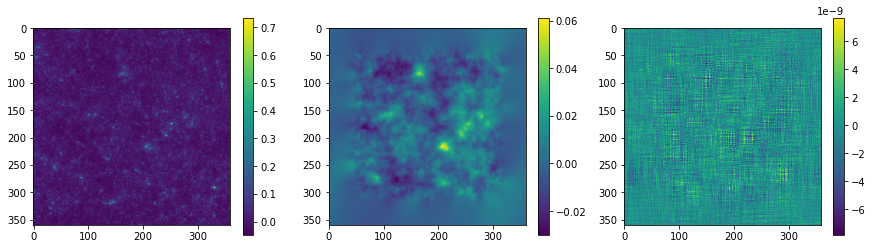

In [18]:
_ = plt.figure(figsize=(15,4))
_ = plt.subplot(131), plt.imshow(test_kappa), plt.colorbar()
_ = plt.subplot(132), plt.imshow(wf_e), plt.colorbar()
_ = plt.subplot(133), plt.imshow(wf_b), plt.colorbar()

In [19]:
wf_samples_e,wf_samples_b  = wiener_sampling.spin_wiener_sampler(test_e[:,:,0], test_e[:,:,1], ncov_diag_e1,ncov_diag_e2, ps_map, ps_map*0., iterations=200, thinning=1)

0.0


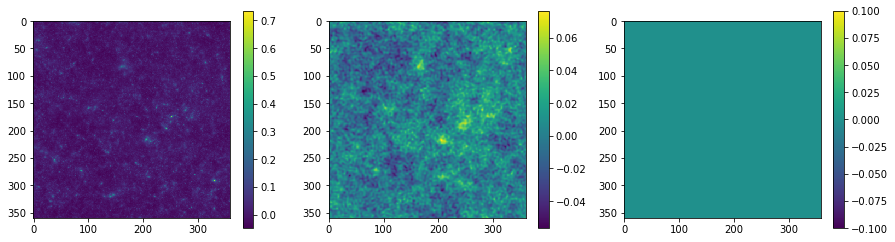

In [20]:
_ = plt.figure(figsize=(15,4))
_ = plt.subplot(131), plt.imshow(test_kappa), plt.colorbar()
_ = plt.subplot(132), plt.imshow(wf_samples_e[35].real), plt.colorbar()
_ = plt.subplot(133), plt.imshow(wf_samples_b[35].real), plt.colorbar()

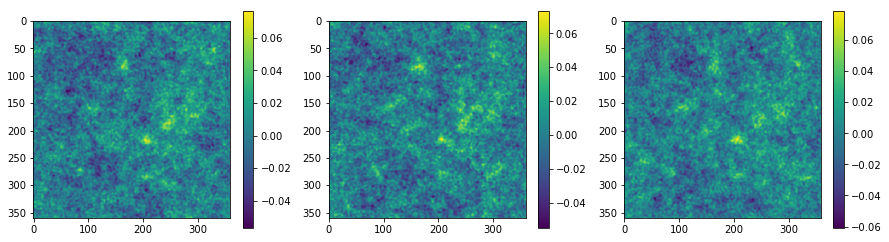

In [21]:
_ = plt.figure(figsize=(15,4))
_ = plt.subplot(131), plt.imshow(wf_samples_e[35].real), plt.colorbar()
_ = plt.subplot(132), plt.imshow(wf_samples_e[36].real), plt.colorbar()
_ = plt.subplot(133), plt.imshow(wf_samples_e[37].real), plt.colorbar()

In [22]:
mean_samples = np.mean(wf_samples_e, axis=0)
std_samples = np.std(wf_samples_e, axis=0)

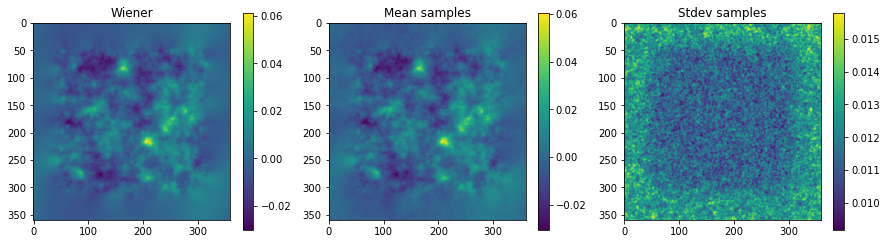

In [23]:
_ = plt.figure(figsize=(15,4))
_ = plt.subplot(131), plt.imshow(wf_e), plt.title('Wiener'), plt.colorbar()
_ = plt.subplot(132), plt.imshow(mean_samples.real, interpolation='None'), plt.title('Mean samples'),  plt.colorbar()
_ = plt.subplot(133), plt.imshow(std_samples.real, interpolation='None'), plt.title('Stdev samples'),  plt.colorbar()

In [24]:
ps_test = spectral.measure_power_spectrum(wf_samples_e[0].real+wf_samples_e[0].imag)
ps_true = spectral.measure_power_spectrum(test_kappa + 1j*test_kappa*0.)

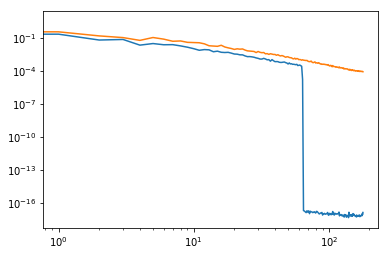

In [25]:
plt.loglog(ps_test)
plt.loglog(ps_true)

**Compare with Neural Score Matching MAP estimation (with gaussian prior)**

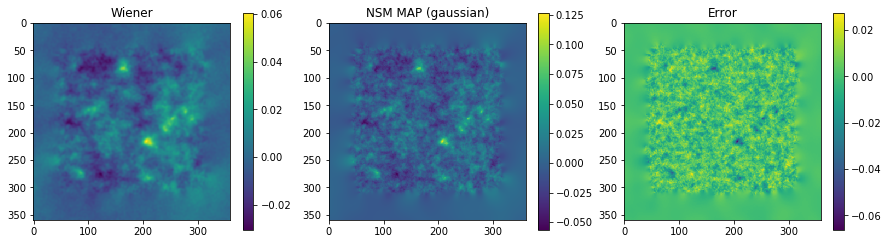

In [26]:
nsm_map = np.load('nsm_gauss_MAPv2.npy')
nsm_mean = np.load('nsm_gauss_meanv2.npy')

_ = plt.figure(figsize=(15,4))
_ = plt.subplot(131), plt.imshow(mean_samples.real), plt.title('Wiener'), plt.colorbar()
_ = plt.subplot(132), plt.imshow(nsm_map, interpolation='None'), plt.title('NSM MAP (gaussian)'),  plt.colorbar()
_ = plt.subplot(133), plt.imshow(wf_e - nsm_map, interpolation='None'), plt.title('Error'),  plt.colorbar()

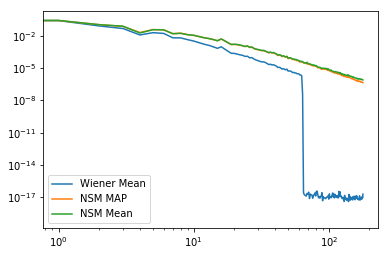

In [27]:
ps_nsm_map = spectral.measure_power_spectrum(nsm_map)
ps_nsm_mean = spectral.measure_power_spectrum(nsm_mean)
ps_wiener = spectral.measure_power_spectrum(wf_e)

plt.loglog(ps_wiener, label='Wiener Mean')
plt.loglog(ps_nsm_map, label='NSM MAP')
plt.loglog(ps_nsm_mean, label='NSM Mean')
plt.legend()